<a href="https://colab.research.google.com/github/jk-math/NLP/blob/main/Sentiment_Analysis_IMDB_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import io

## Downloading and preprocessing the data





Download the IMDB Reviews raw data

In [2]:
import urllib.request
import tarfile
thetarfile = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall()

Get the file paths for all of the reviews so that we can read the reviews from each text file and put them together into one large dataset

In [3]:
# Get the file names from a particular folder
import os             
train_files_pos = os.listdir('./aclImdb/train/pos')
print(train_files_pos[0:5])

['4041_7.txt', '10951_8.txt', '10203_10.txt', '7314_10.txt', '1967_8.txt']


In [4]:
# Gets the entire file path
import glob
train_pos_txt_files = glob.glob('./aclImdb/train/pos/*.txt')
train_neg_txt_files = glob.glob('./aclImdb/train/neg/*.txt')
test_pos_txt_files = glob.glob('./aclImdb/test/pos/*.txt')
test_neg_txt_files = glob.glob('./aclImdb/test/neg/*.txt')
print(train_pos_txt_files[0:3])
pos_files = [train_pos_txt_files, test_pos_txt_files]
neg_files = [train_neg_txt_files, test_neg_txt_files]

['./aclImdb/train/pos/4041_7.txt', './aclImdb/train/pos/10951_8.txt', './aclImdb/train/pos/10203_10.txt']


The reviews contain HTML tags, so we remove them

In [5]:
import re

def clean_html(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext.lower() # the tokenizer converts to lowercase as a default

Remove HTML tags from all reviews and store the reviews as strings in a list

In [6]:
pos_reviews = []
neg_reviews = []
for collection in pos_files:
  for path in collection:
    with open(path, 'r') as f:
      pos_reviews.append(clean_html(f.read()))
for collection in neg_files:
  for path in collection:
    with open(path, 'r') as f:
      neg_reviews.append(clean_html(f.read()))

Create training, validation, and test sets

In [7]:
train_revs = pos_reviews[:20000] + neg_reviews[:20000]
train_labels = [1]*20000 + [0]*20000
valid_revs = pos_reviews[20000:22500]+neg_reviews[20000:22500]
valid_labels = [1]*2500 + [0]*2500
test_revs = pos_reviews[22500:]+neg_reviews[22500:]
test_labels = [1]*2500 + [0]*2500

Shuffle the data prior to training. We only need to shuffle the training and validation data

In [8]:
def shuffle_data(x,y):
  data = list(zip(x,y))
  random.shuffle(data)
  return zip(*data)

In [9]:
train_revs, train_labels = shuffle_data(train_revs, train_labels)

valid_revs, valid_labels = shuffle_data(valid_revs, valid_labels)

test_revs, test_labels = shuffle_data(test_revs, test_labels)

Tokenize and pad the reviews

In [10]:
# these same parameters are used in every model
vocab_size = 50000
max_length = 250
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_revs)
word_index = tokenizer.word_index

# switch key, value for the word index so that we can use the token (number) as the key
# look up the corresponding word
word_index = dict([(value,key) for key, value in word_index.items()])

In [11]:
def toke_and_pad(sentences, max_len = 250, trunc_type = 'post', pad_type = 'post'):
  tokenized = tokenizer.texts_to_sequences(sentences)
  tokenized_and_padded = pad_sequences(tokenized, maxlen=max_len, truncating=trunc_type, padding=pad_type)
  return tokenized_and_padded

In [12]:
# Pad the sequences so that they are all the same length
x_train = toke_and_pad(train_revs)
x_valid = toke_and_pad(valid_revs)
x_test = toke_and_pad(test_revs)

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Create Tensorflow Dataset and batch the data for quicker training

In [13]:
train = tf.data.Dataset.from_tensor_slices((x_train, train_labels)) 
valid = tf.data.Dataset.from_tensor_slices((x_valid, valid_labels))
test = tf.data.Dataset.from_tensor_slices((x_test, test_labels))

In [14]:
train = train.shuffle(20000).batch(128).prefetch(1)
valid = valid.shuffle(5000).batch(128).prefetch(1)

## Define functions for training

In [15]:
def plot_training_metrics(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Acc')
  plt.plot(epochs_range, val_acc, label='Validation Acc')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Acc')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  plt.close()

In [16]:
def get_embed_visual_files(model):
  # First get the weights of the embedding layer
  e = model.layers[0]
  weights = e.get_weights()[0]
  print(weights.shape) # shape: (vocab_size, embedding_dim)

  # Write out the embedding vectors and metadata
  out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
  out_m = io.open('meta.tsv', 'w', encoding='utf-8')
  for word_num in range(1, vocab_size):
    word = word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
  out_v.close()
  out_m.close()

  # Download the files
  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [17]:
def fit_model(model, return_preds = False, num_epochs = 100): # input a compiled model
  # the input_dim and the input_length of the embedding layer
  # must match the vocab size and max length parameters of the Tokenizer, respectively
  # the same training, validation, and test sets are used
  early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                              restore_best_weights = True, patience = 5)
  # check_point = tf.keras.callbacks.ModelCheckpoint('model_checkpoint', monitor = 'val_accuracy', save_weights_only = True, save_freq = 'epoch')
  model.summary()
  history = model.fit(train, 
          epochs=num_epochs, 
          validation_data=valid,
          callbacks = [early_stop],
          verbose = 0) # early stopping will be used in training every model
  plot_training_metrics(history)
  test_acc = model.evaluate(x_test, test_labels)
  print('The accuracy of this model on the unseen test set is {}'.format(round(test_acc[1],4)))
  if return_preds == True:
    pred_proba = model.predict(x_test)
    pred_labels = [0 if p < 0.5 else 1 for p in pred_proba]
    return history, pred_labels
  else:
    return history

In [18]:
def print_incorrect_preds(pred_labels, true_labels, num=5): # print some of the reviews which are incorrectly classified by a model
  j = 0
  for i in range(len(pred_labels)):
    if j < num:
      if pred_labels[i] == test_labels[i]:
        continue
      else:
        j += 1
        print('The following review is predicted to be {}, but it is {}'.format(pred_labels[i], test_labels[i]))
        print((test_revs[i]))
        print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 25)           1250000   
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2510      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,252,521
Trainable params: 1,252,521
Non-trainable params: 0
_________________________________________________________________


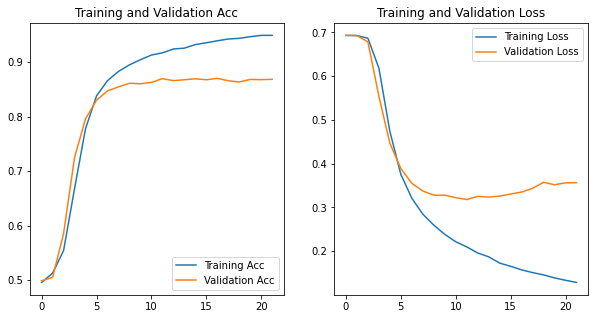

157/157 [==============================] - 0s 2ms/step - loss: 0.3248 - accuracy: 0.8670
The accuracy of this model on the unseen test set is 0.867


In [19]:
tf.keras.backend.clear_session()
embedding_dim = 25
globalMaxPool_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPooling1D(data_format='channels_first'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
globalMaxPool_model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

globalMaxPool_history, globalMaxPool_preds = fit_model(globalMaxPool_model,return_preds = True)

In [20]:
print_incorrect_preds(globalMaxPool_preds, test_labels)

The following review is predicted to be 0, but it is 1
***spoilers*** ***spoilers*** wow, what a predicament joanna has found herself in. after accidentally running over a young child, she goes to call for help, only to return to the crime scene amidst a group of very angry onlookers. understanda- bly, this is too much for her to handle, and she flees the scene. luckily the child didn't die, but is seriously injured and in a coma. so starts the biggest struggle in joanna's life: should she keep quiet or speak up? at first she doesn't, but eventually she realises that it's torture living with such a horrible secret.at one point she even joins a search party to help find the culprit. and gradually a detective starts to question this woman's behavior. she wants to tell the truth, and she never meant to run away from the crime scene, but is it worth telling and having the whole town hate you for it?the thing about this movie is that you don't choose sides. joanna is very much a good role m

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 25)           1250000   
_________________________________________________________________
conv1d (Conv1D)              (None, 244, 32)           5632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 121, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                38730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

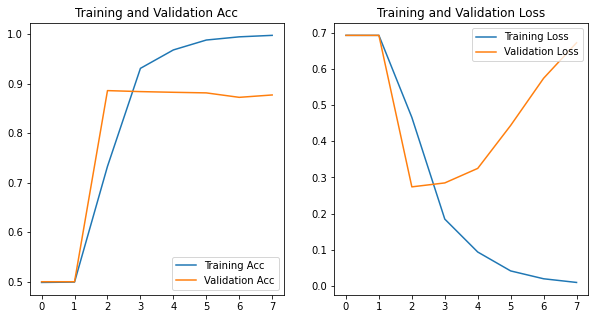

157/157 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.8894
The accuracy of this model on the unseen test set is 0.8894


In [21]:
tf.keras.backend.clear_session()

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 25, input_length = max_length),
    tf.keras.layers.Conv1D(32, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
cnn_history, cnn_preds = fit_model(model_cnn, return_preds = True)

In [22]:
print_incorrect_preds(cnn_preds, test_labels)

The following review is predicted to be 1, but it is 0
a brilliant professor and his sidekick journey to the center of the earth in a huge machine which screws its way to the core. there, naturally, they find all kinds of things that are intent on killing and eating them. plus, of course, a love interest for the young sidekick. ho hum, does the plot never take a different tack?

The following review is predicted to be 0, but it is 1
it's a sad state in corporate hollywood when a movie surprises you by not taking routes you've been seeing in the movie house since day one. i had literally no idea how this film was going to end, because it went left when i expected it to go right, zigged when i expected a zag, etc. this could have easily unraveled into generic suspense thriller, or depressing white trash drama, but it stayed a course all its own till the end. it is a sad story, though. not because of what happens to alice, but because of the sad world that surrounds her and leads her down

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               44544     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,544,673
Trainable params: 2,544,673
Non-trainable params: 0
_________________________________________________________________


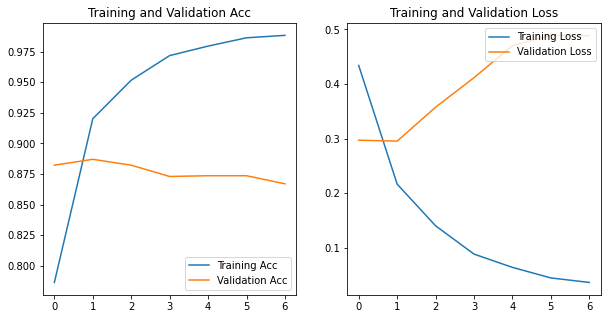

157/157 [==============================] - 1s 9ms/step - loss: 0.2855 - accuracy: 0.8838
The accuracy of this model on the unseen test set is 0.8838


In [23]:
tf.keras.backend.clear_session()

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_history, gru_preds = fit_model(model_gru, return_preds = True)

In [24]:
print_incorrect_preds(gru_preds, test_labels)

The following review is predicted to be 0, but it is 1
david "master of debonair" niven plays the big boss (ivan) who preys upon the unfortunate richard jordan (pinky) by forcing the hapless ex-con to exploit his ill-found new position in a bank. elke sommer (miss pelham) most effectively provides the female interest, whom pinkie cannot simply cannot resist.it seems they were unable to decide on one name for this film so instead they used four .... makes sense ???sadly, this turn out to be one of niven's last roles.overall, this film is fun and well worth watching if you manage to catch one of its rare or late night tv screenings.

The following review is predicted to be 1, but it is 0
a brilliant professor and his sidekick journey to the center of the earth in a huge machine which screws its way to the core. there, naturally, they find all kinds of things that are intent on killing and eating them. plus, of course, a love interest for the young sidekick. ho hum, does the plot never ta

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           2500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,559,009
Trainable params: 2,559,009
Non-trainable params: 0
_________________________________________________________________


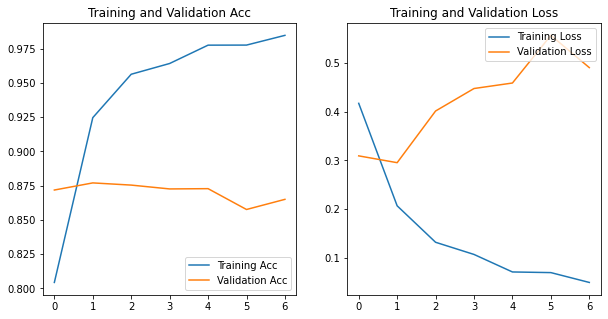

157/157 [==============================] - 2s 10ms/step - loss: 0.2897 - accuracy: 0.8810
The accuracy of this model on the unseen test set is 0.881


In [25]:
tf.keras.backend.clear_session()

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

lstm_history, lstm_preds = fit_model(model_lstm, return_preds = True)

In [26]:
print_incorrect_preds(lstm_preds, test_labels)

The following review is predicted to be 0, but it is 1
having recently seen grindhouse, i was browsing in video usa looking for some movies that might have played in real grindhouse theatres in downtown areas during the '70s. the hong kong action flick five fingers of death seemed just such a picture. the cartoon-like sound effects and the quick jump cuts seemed a little distracting at first but after a while i was so involved in the story and the characters i didn't care. parts of the music score sounded like the "ironside" tv theme song that was subsequently used in quentin tarantino's kill bill movies. some scenes involving the hero's fiancé seemed to border on parody but they were so brief that they didn't ruin the film. the most exciting parts involve the tournament and some revenge segments after that. well worth seeing for kung fu fans!

The following review is predicted to be 0, but it is 1
***spoilers*** ***spoilers*** wow, what a predicament joanna has found herself in. after

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 25)           1250000   
_________________________________________________________________
conv1d (Conv1D)              (None, 244, 32)           5632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 121, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                38730     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

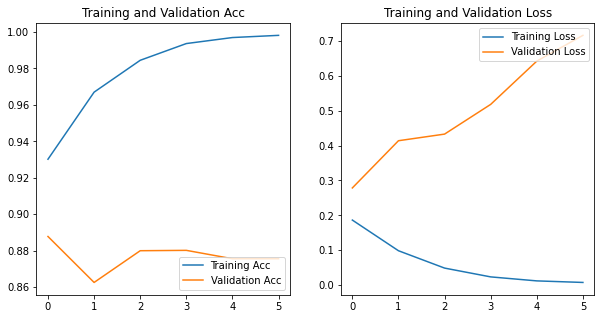

157/157 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.8894
The accuracy of this model on the unseen test set is 0.8894


In [27]:
tf.keras.backend.clear_session()

hybrid_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 50, input_length=max_length),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4, strides = 2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

hybrid_model.compile(loss='binary_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
hybrid_history, hybrid_preds = fit_model(model_cnn, return_preds = True)

If we want to use these models to predict sentiment on new reviews, we need to put those reviews into a list and we need to process (tokenize and pad) the reviews 

In [28]:
new_revs = ['this movie was really bad. I hated it and it might be the worst thing ever',
            'Oh boy it was too long and it was far from the best',
            'Boy and girl meet and fall in love. They go out on dates and eat food. If you like romance, then you will like this movie. It was excellent',
            'I expected this movie to be really bad, but I was pleasantly surprised. The movie is a little too long and some of the jokes are bad, but overall it was good.']

new_revs = toke_and_pad(new_revs)

In [29]:
globalMaxPool_model.predict(new_revs)

array([[0.05070204],
       [0.37343082],
       [0.74314916],
       [0.57736444]], dtype=float32)

In [30]:
model_cnn.predict(new_revs)

array([[0.01122269],
       [0.4525792 ],
       [0.8942459 ],
       [0.5825435 ]], dtype=float32)

In [31]:
model_gru.predict(new_revs)

array([[0.03471078],
       [0.540851  ],
       [0.93670803],
       [0.7728298 ]], dtype=float32)

In [32]:
model_lstm.predict(new_revs)

array([[0.02064683],
       [0.4793361 ],
       [0.7861748 ],
       [0.7808129 ]], dtype=float32)

In [33]:
hybrid_model.predict(new_revs)

array([[0.5038468 ],
       [0.50312513],
       [0.5066057 ],
       [0.5060672 ]], dtype=float32)